# Checkout the dataset
Dataset: [bbc dataset][def]  
- 根據文章片段，分類該文章是屬於什麼領域的報導
- 總共有五種分類：entertainment, sport, tech, business, politics
- 資料總筆數：2225

我們可以從下方圖表得知：  
* 此資料集有五種類別，即是等等 BERT 判斷分類的 Label  
* 而每筆 Text 就是 BERT 的 input 資料

目的就是判斷此 Text 的類別 (Label) 是什麼  

[def]: https://www.kaggle.com/datasets/sainijagjit/bbc-dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

datapath = 'bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


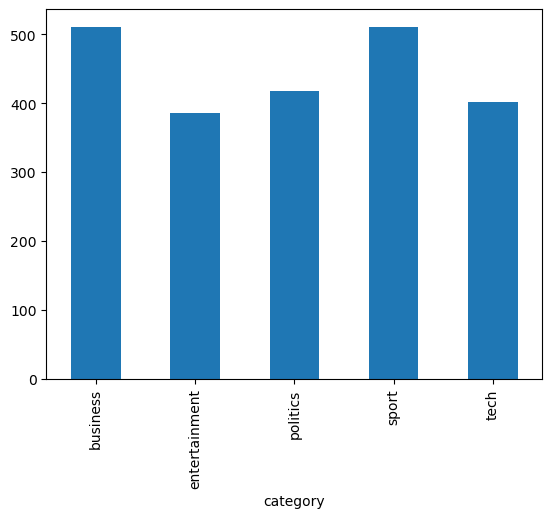

In [2]:
df.groupby(['category']).size().plot.bar()

# Preprocessing Data (資料前處理)

## 1. BertTokenizer
[**BertTokenizer**](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer):
以 Word-based 的方式做 Tokenization，並加上 \[CLS\]、\[SEP\]、\[PAD\] 這三個特殊 token  
使用方式為： ```BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)```   
其中，```PRETRAINED_MODEL_NAME``` 可依需求尋找適合任務的預訓練模型 ([可用模型總攬](https://huggingface.co/models))  
本例子使用常見的英文模型 ```'bert-base-cased'```

BertTokenizer 繼承於 [PreTrainedTokenizer](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer)，其中較常使用的參數如下：

* ```text``` / ```text_pair ```: 要做 Tokenize 的序列 / 要做 Tokenize 的一對序列
* ```padding```: 選擇要不要補 padding (\[PAD\])  
  * ```True``` or ```'longest'```: 做 padding 直到序列長度等於 batch 中最長的序列
  * ```'max_length'```: padding 直到設定的值 'max_length'
  * ```False``` or ```'do_not_pad'```: 不做 padding
* ```max_length```: 設定序列的最長長度 (BERT 中是 512) 
* ```truncation```: 若序列(序列對)長度總和大於上限，是否截斷序列
  * ```True``` or ```'longest_first'```: 以迭代的方式，從最長的序列開始慢慢截斷。  
    ex:  
    seq1 = "a b c", seq2 = "d e", max_length = 2。因為 len(seq1) + len(seq2) > 2，需要要做截斷  
    (註：這邊先忽略 \[CLS\]、\[SEP\]、\[PAD\] 這些 Token)  
    迭代1：seq1 = "a b", seq2 = "d e"  
    迭代2：seq1 = "a", seq2 = "d e"  
    迭代3：seq1 = "a", seq2 = "d" => 最後輸出 "a d"  
  * ```'only_first'```: 只截斷一對序列對中的第一個序列
  * ```'only_second'```: 只截斷一對序列對中的第二個序列
  * ```False``` or ```'do_not_truncate'```: 不做截斷
* ```return_tensors```: 決定回傳張量的資料型態
  * ```'tf'```: TensorFlow tf.constant.
  * ```'pt'```: PyTorch torch.Tensor.
  * ```'np'```: Numpy np.ndarray.

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text1 = 'I am practicing using Bert Model'
example_text2 = 'I am trying'
bert_input = tokenizer(example_text1, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")
bert_input2 = tokenizer(example_text1,example_text2, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

c:\Users\User\anaconda3\envs\BERT_Practice\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


`BertTokenizer` 的輸出 (這邊為 `bert_input`) 有三種：
* `input_ids`: 輸出每個 token 代表的數字代號  
    (其中 \[CLS\] = 101, \[SEP\] = 102, \[PAD\] = 0)
* `token_type_ids`: 輸出每個 token 是屬於序列對中的哪一個序列，用 0、1 表示  
    (如果輸入序列只有一個，那每個 token 都是 0)
    (啊簡單來說就是讓 BERT 知道 Token 屬於哪個句子)
* `attention_mask`: 判斷各個 token 是原句資訊還是 padding  
    如果該 token 是 真實的字、\[CLS\]、\[SEP\]：輸出 1  
    如果該 token 是 \[PAD\]：輸出 0

In [4]:
print("Sequence: ", example_text1)
print("input_ids: ",bert_input['input_ids'])
print("token_type_ids: ", bert_input['token_type_ids'])
print("attention_mask: ", bert_input['attention_mask'])

example_text1_decode = tokenizer.decode(bert_input.input_ids[0])

print("decode: ",example_text1_decode)
print("-----------------------------------------------------------")
print("Sequence1: ", example_text1)
print("Sequence2: ", example_text2)
print("input_ids: ",bert_input2['input_ids'])
print("token_type_ids: ", bert_input2['token_type_ids'])
print("attention_mask: ", bert_input2['attention_mask'])

example_text2_decode = tokenizer.decode(bert_input2.input_ids[0])

print("decode: ",example_text2_decode)

Sequence:  I am practicing using Bert Model
input_ids:  tensor([[  101,   146,  1821, 13029,  1606, 15035,  6747,   102,     0,     0]])
token_type_ids:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])
decode:  [CLS] I am practicing using Bert Model [SEP] [PAD] [PAD]
-----------------------------------------------------------
Sequence1:  I am practicing using Bert Model
Sequence2:  I am trying
input_ids:  tensor([[  101,   146,  1821, 13029,  1606,   102,   146,  1821,  1774,   102]])
token_type_ids:  tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
attention_mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
decode:  [CLS] I am practicing using [SEP] I am trying [SEP]


## 2. Data Class
1. 決定要用什麼模型的 tokenizer  
2. 給定對應到 Dataset 類別的標籤 (labels)，即將資料集中的各類別對應到 id (數值)  
   這邊將 ```'business'```, ```'entertainment'```, ```'sport'```, ```'tech'```, ```'politics'``` 對應到 0 ~ 4，
3. 初始化 Dataset 時：
   - 各筆資料的分類 (category) 轉換成 id
   - 再把資料集丟進 BertTokenizer，轉換成 BERT 可以使用的格式

In [5]:
import torch
import numpy as np
from transformers import BertTokenizer

# 決定 tokenizer 類型
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# 決定資料集中各分類對應的 id
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

# 資料集處理
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # 把每一筆資料的類別改成 id
        self.labels = [labels[label] for label in df['category']]  
        # 對每筆資料做 BERT tokenize
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    # 回傳資料集各類別 (id)
    def classes(self):
        return self.labels

    # 回傳該 label 的資料數
    def __len__(self):
        return len(self.labels)

    # 取得當前資料的 label
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    # 取得當前資料的 text
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

切分 訓練 (training)、驗證 (validation)、測試 (testing) 資料集   
這邊切分比例為 80:10:10  

註：
1. ```df.sample(frac=1, random_state=42)```：從 dataframe 隨機取樣  
   ```frac```：要抽取 dataframe 的比例 (0 ~ 1)  
   ```random_state```：隨機的狀態，可以想樣乘亂數表的位置 (？)  
2. ```np.split(..., [int(.8*len(df)), int(.9*len(df))])```：把陣列做分割  
   上述第二個參數的 list，代表分別取道的相對位置，分割個數 = 該 list 的長度，以本例子來說：  
   第一區塊：```int(.8*len(df))```：取到 df 的 80 % => 分割的第一組陣列是 0% ~ 80% 的 df  
   第二區塊：```int(.9*len(df))```：取到 df 的 90 % => 分割的第一組陣列是 80% ~ 90% 的 df  
   第三區塊：分割的第一組陣列是 90% ~ 100% 的 df  

In [6]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


# Model Building
[**BertModel**](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel)：主要是 transformer 的 Encoder 部分  
繼承於 [PreTrainedModel](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/model#transformers.PreTrainedModel)，在 ```forward```中較常使用的參數如下：  
* ```input_ids```: 輸入序列  
* ```attention_mask```: 輸入序列對應的 mask，以告知 attention 略過他們  
  1: 該 token 是 真實的字、\[CLS\]、\[SEP\]  
  0: 該 token 是 \[PAD\]，即要被 mask 掉的部分
* ```return_dict ```: True: 回傳值是 [ModelOutput](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/output#transformers.utils.ModelOutput)；False: 回傳值是 tuple

若 ```return_dict = True```，BertModel 的輸出為 [transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions](https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions)  
而範例中，```return_dict = False```，BertModel 的輸出為 ```tuple(torch.FloatTensor)```，範例以 ```_``` 與 ```pooled_output``` 表示：
* ```_```: sequence output，為序列在 BERT 最後一層 hidden layer 的輸出
* ```pooled_output```: 取出 BERT 最後一層 layer中，\[CLS\] 對應的向量 (vector)  
由上可知，BERT 可以處理序列任務 (如輸出```_```) 及 分類、迴歸分析任務 (如輸出```pooled_output```)

我們把 ```pooled_output``` 經過 dropout、線性轉換、ReLU 激活函數後，我們在最後的線性層可以得到維度為 5 的向量，代表著我們資料及的分類 (sport, business, politics, entertainment, and tech)

In [7]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()                      # 繼承 nn.Module

        self.bert = BertModel.from_pretrained('bert-base-cased')    # 選擇 Model
        self.dropout = nn.Dropout(dropout)                          # dropout = 0.5 => 去掉 50% neural，避免 overfitting
        self.linear = nn.Linear(768, 5)                             # BERT Base size: 768，每句有 5 種可能的分類要做選擇  
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# Training Loop
* Epoch: 4
* Loss Function: Categorical cross entropy (因為要做複數類別分類)
* Optimizer: Adam
* Learning Rate: 10<sup>-6</sup> (1e-6)

In [8]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    # 把原本的資料經過 Dataset 類別包裝起來
    train, val = Dataset(train_data), Dataset(val_data)

    # 把訓練、驗證資料集丟進 Dataloader 定義取樣資訊 (ex: 設定 batch_size...等等)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    # 偵測有 GPU，有就用
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()                       # Loss Function: Categorical cross entropy
    optimizer = Adam(model.parameters(), lr= learning_rate) # Optimizer: Adam

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    # 每次完整訓練 (每個 epoch) 要做的事
    for epoch_num in range(epochs):

            # ---------- 訓練的部分 ----------
            total_acc_train = 0
            total_loss_train = 0

            # 這邊加上 tqdm 模組來顯示 dataloader 處理進度條
            # 所以在程式意義上，可以直接把這行當作 for train_input, train_label in train_dataloader:
            for train_input, train_label in tqdm(train_dataloader):

                # .to(device): 把東西 (tensor) 丟到 GPU 的概念
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                # 把 data 丟進 BERT
                output = model(input_id, mask)
                
                # 計算 Cross Entropy，以此計算 loss
                batch_loss = criterion(output, train_label.long())  # 參數解釋：(模型的輸出, 原本預計的輸出)
                total_loss_train += batch_loss.item()               # .item(): tensor 轉 純量
                
                # 看 model output "可能性最高" 的 label 是不是和 data 一樣，是的話，acc + 1
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()       # 清空前一次 Gradient
                batch_loss.backward()   # 根據 lost 計算 back propagation
                optimizer.step()        # 做 Gradient Decent
            
            # ---------- 驗證的部分 ----------
            total_acc_val = 0
            total_loss_val = 0

            # 步驟和訓練時差不多，差在沒做 Gradient Decent
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Downloading: 100%|██████████| 416M/416M [02:56<00:00, 2.47MB/s] 
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [07:40<00:00,  1.93it/s]


Epochs: 1 | Train Loss:  0.749                 | Train Accuracy:  0.348                 | Val Loss:  0.646                 | Val Accuracy:  0.482


100%|██████████| 890/890 [07:55<00:00,  1.87it/s]


Epochs: 2 | Train Loss:  0.591                 | Train Accuracy:  0.562                 | Val Loss:  0.465                 | Val Accuracy:  0.716


100%|██████████| 890/890 [07:57<00:00,  1.86it/s]


Epochs: 3 | Train Loss:  0.340                 | Train Accuracy:  0.821                 | Val Loss:  0.154                 | Val Accuracy:  0.986


100%|██████████| 890/890 [08:00<00:00,  1.85it/s]


Epochs: 4 | Train Loss:  0.118                 | Train Accuracy:  0.971                 | Val Loss:  0.080                 | Val Accuracy:  0.991


100%|██████████| 890/890 [08:01<00:00,  1.85it/s]


Epochs: 5 | Train Loss:  0.061                 | Train Accuracy:  0.988                 | Val Loss:  0.045                 | Val Accuracy:  0.995


# Evaluate Model on Test Data
把最後 10% 的 Unseen Data 拿來做測試  
程式流程基本上和驗證差不多

In [9]:
def evaluate(model, test_data):

    # 把那 10% unseen data 拿來用
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # 不用做 loss 了，所以不用丟 criterion 進去
    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.996
